In [7]:
import importlib.util
import sys

module_path = "5.1.analyzer.py"
module_name = "analyzer"

spec = importlib.util.spec_from_file_location(module_name, module_path)
module = importlib.util.module_from_spec(spec)
sys.modules[module_name] = module
spec.loader.exec_module(module)


analyzer = module.DataAnalyzer()


INFO:numexpr.utils:Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO:numexpr.utils:NumExpr defaulting to 16 threads.
INFO:Data Analyzer:加载预处理后的文本语料库
INFO:Data Analyzer:加载france的education领域数据
加载france的education领域数据: 100%|██████████| 88/88 [00:00<00:00, 968.66it/s]
INFO:Data Analyzer:加载france的financial领域数据
加载france的financial领域数据: 100%|██████████| 88/88 [00:00<00:00, 1504.05it/s]
INFO:Data Analyzer:加载france的healthcare领域数据
加载france的healthcare领域数据: 100%|██████████| 88/88 [00:00<00:00, 1219.36it/s]
INFO:Data Analyzer:加载france的industrial领域数据
加载france的industrial领域数据: 100%|██████████| 88/88 [00:00<00:00, 1422.06it/s]
INFO:Data Analyzer:加载france的public_services领域数据
加载france的public_services领域数据: 100%|██████████| 88/88 [00:00<00:00, 1414.77it/s]
INFO:Data Analyzer:加载china的education领域数据
加载china的education领域数据: 100%|██████████| 88/88 [00:00<00:00, 2000.99it/s]
INFO:Data Analyzer:加载china的financial领域数据
加载china的financial领域数据: 100%|██████████| 88/88 [0

In [8]:
import os
import numpy as np
import asyncio
from tqdm.notebook import tqdm
import httpx
from typing import *
import logging

logger = logging.getLogger('UAI')

# 假定这两个异步函数已经定义：
#   async def _get_embedding(text: str) -> List[float]
#   async def _embed_sentences(sentences: List[str], max_concurrency=100, batch_size=256) -> List[List[float]]

base_url = "https://api.siliconflow.cn/v1/embeddings"
payload_model = "Pro/BAAI/bge-m3"
api_key = os.environ.get("DEEPSEEK_API_KEY")

async def _get_embedding(text: str, timeout: float = 60.0) -> List[float]:
    """Call SiliconFlow, return embedding list."""
    payload = {"model": payload_model, "input": text, "encoding_format": "float"}
    headers = {"Authorization": f"Bearer {api_key}", "Content-Type": "application/json"}
    async with httpx.AsyncClient(timeout=timeout) as client:
        r = await client.post(base_url, json=payload, headers=headers)
        r.raise_for_status()
        return r.json()["data"][0]["embedding"]

async def _embed_sentences(sentences, max_concurrency=100,
                           batch_size=1024, retries=10, base_backoff=3.0):
    """
    并发获取句子嵌入：
    - tqdm 进度条
    - 每条句子在 RequestError/Timeout 时自动重试 (指数退避)
    """
    sem = asyncio.Semaphore(max_concurrency)
    pbar = tqdm(total=len(sentences), desc="Embedding sentences", ncols=80)

    async def _embed_once(text):
        async with sem:
            return await _get_embedding(text)

    async def _embed_with_retry(text):
        for attempt in range(retries):
            try:
                return await _embed_once(text)
            except (httpx.RequestError, httpx.HTTPStatusError) as exc:
                if attempt == retries - 1:
                    logger.error(f"获取嵌入失败（已重试 {retries} 次）: {exc}")
                    # 仍抛出，让上层决定如何处理（可改为返回 None）
                    raise
                backoff = base_backoff * 2 ** attempt
                logger.warning(f"请求失败，第 {attempt+1} 次重试，等待 {backoff:.1f}s")
                await asyncio.sleep(backoff)

    results, idx = [], 0
    while idx < len(sentences):
        batch = sentences[idx: idx + batch_size]
        batch_embs = await asyncio.gather(*[_embed_with_retry(t) for t in batch])
        results.extend(batch_embs)
        idx += len(batch)
        pbar.update(len(batch))

    pbar.close()
    return results


def flatten_sentence_lists(sent_lists: List[List[str]]) -> List[str]:
    """把多篇文档的句子列表展平成一个大句子列表并去除空串"""
    return [s for sub in sent_lists for s in sub if s and s.strip()]

async def _compute_and_save_one(country: str, domain: str, sentences: List[str], embedding_dir: str):
    """批量嵌入并保存单个 country_domain 的句向量文件"""
    os.makedirs(embedding_dir, exist_ok=True)
    cache_file = os.path.join(embedding_dir, f"{country}_{domain}_sentence_embs.npy")
    if os.path.exists(cache_file):
        print(f"[跳过] 已存在：{cache_file}")
        return

    print(f"[嵌入] {country} / {domain}: 共 {len(sentences)} 句")
    # 异步并发获取嵌入
    embs = await _embed_sentences(sentences)
    arr = np.asarray(embs, dtype=np.float32)
    # 保存到 .npy
    np.save(cache_file, arr)
    print(f"[保存] {cache_file}")

def compute_all_embeddings(corpus_sentences: Dict[str, Dict[str, List[List[str]]]],
                           embedding_dir: str):
    """
    corpus_sentences: {
      'china': {'finance': [['句1','句2'], …], 'education': […], …},
      'france': {'finance': […], …}
    }
    embedding_dir: 嵌入文件存放目录
    """
    async def _run_tasks():
        tasks = []
        for country, domains in corpus_sentences.items():
            for domain, sent_lists in domains.items():
                # 展平成一维句子列表
                sentences = flatten_sentence_lists(sent_lists)
                if not sentences:
                    print(f"[警告] {country}/{domain} 无句子，跳过")
                    continue
                tasks.append(_compute_and_save_one(country, domain, sentences, embedding_dir))
        await asyncio.gather(*tasks)

    asyncio.run(_run_tasks())


In [9]:
from config import EMBEDDINGS_DIR
embedding_dir = EMBEDDINGS_DIR
corpus_sentences = analyzer.corpus

In [10]:
corpus_sentences = {
    'china': analyzer.corpus['china']['sentences'],
    'france': analyzer.corpus['france']['sentences'],
}

In [5]:
import nest_asyncio
nest_asyncio.apply()
compute_all_embeddings(corpus_sentences, embedding_dir)

[嵌入] china / education: 共 6099 句


Embedding sentences:   0%|                             | 0/6099 [00:00<?, ?it/s]

[嵌入] china / financial: 共 22796 句


[嵌入] china / healthcare: 共 6103 句


[嵌入] china / industrial: 共 20284 句


[嵌入] china / public_services: 共 6387 句


[嵌入] france / education: 共 50167 句


[嵌入] france / financial: 共 26191 句


[嵌入] france / healthcare: 共 23774 句


[嵌入] france / industrial: 共 30438 句


[嵌入] france / public_services: 共 26367 句



















Embedding sentences:  17%|███               | 1024/6099 [02:57<14:38,  5.77it/s]



















































Embedding sentences:  34%|██████            | 2048/6099 [06:07<12:12,  5.53it/s]




































Embedding sentences:  50%|█████████         | 3072/6099 [09:18<09:15,  5.45it/s]














Embedding sentences:  67%|████████████      | 4096/6099 [12:32<06:11,  5.39it/s]

































Embedding sentences:  84%|███████████████   | 5120/6099 [15:47<03:03,  5.34it/s]






































Embedding sentences: 100%|██████████████████| 6387/6387 [18:38<00:00,  5.71it/s]


[保存] c:\Users\ming\OneDrive\本科\法语毕业论文\project\data\embeds\china_public_services_sentence_embs.npy



Embedding sentences: 100%|██████████████████| 6103/6103 [18:59<00:00,  5.36it/s]


[保存] c:\Users\ming\OneDrive\本科\法语毕业论文\project\data\embeds\china_healthcare_sentence_embs.npy


Embedding sentences: 100%|██████████████████| 6099/6099 [18:59<00:00,  5.35it/s]


[保存] c:\Users\ming\OneDrive\本科\法语毕业论文\project\data\embeds\china_education_sentence_embs.npy




































































































































































































































































































































































































































































Embedding sentences: 100%|████████████████| 20284/20284 [51:05<00:00,  6.62it/s]


[保存] c:\Users\ming\OneDrive\本科\法语毕业论文\project\data\embeds\china_industrial_sentence_embs.npy






























































Embedding sentences: 100%|████████████████| 22796/22796 [55:37<00:00,  6.83it/s]


[保存] c:\Users\ming\OneDrive\本科\法语毕业论文\project\data\embeds\china_financial_sentence_embs.npy




































































Embedding sentences: 100%|████████████████| 23774/23774 [57:51<00:00,  6.85it/s]


[保存] c:\Users\ming\OneDrive\本科\法语毕业论文\project\data\embeds\france_healthcare_sentence_embs.npy







































































































Embedding sentences: 100%|██████████████| 26191/26191 [1:01:41<00:00,  7.08it/s]


[保存] c:\Users\ming\OneDrive\本科\法语毕业论文\project\data\embeds\france_financial_sentence_embs.npy










Embedding sentences: 100%|██████████████| 26367/26367 [1:01:55<00:00,  7.10it/s]


[保存] c:\Users\ming\OneDrive\本科\法语毕业论文\project\data\embeds\france_public_services_sentence_embs.npy

































































































Embedding sentences: 100%|██████████████| 30438/30438 [1:05:50<00:00,  7.70it/s]


[保存] c:\Users\ming\OneDrive\本科\法语毕业论文\project\data\embeds\france_industrial_sentence_embs.npy






























































































































































Embedding sentences: 100%|██████████████| 50167/50167 [1:21:06<00:00, 10.31it/s]


[保存] c:\Users\ming\OneDrive\本科\法语毕业论文\project\data\embeds\france_education_sentence_embs.npy


In [11]:
HOFSTEDE_REFERENCE = {
    "china":  {
        "power_distance": 80, "individualism": 20, "motivation_towards_achievement": 66,
        "uncertainty_avoidance": 30, "long_term_orientation": 87, "indulgence": 24,
    },
    "france": {
        "power_distance": 68, "individualism": 71, "motivation_towards_achievement": 43,
        "uncertainty_avoidance": 86, "long_term_orientation": 63, "indulgence": 48,
    },
}

HOFSTEDE_FINANCE_ZH = {
     "power_distance": {
        "pos": [{"txt": "集中管理", "w": 2}, {"txt": "风险审批流程", "w": 1.5}, {"txt": "监管指导", "w": 1}],
        "neg": [{"txt": "灵活授权", "w": 2}, {"txt": "自主定价", "w": 1.5}, {"txt": "团队共识", "w": 1}],
    },
    "individualism": {
        "pos": [{"txt": "客户定制", "w": 2}, {"txt": "个性化服务", "w": 1.5}, {"txt": "客户自主选择", "w": 1}],
        "neg": [{"txt": "标准产品", "w": 2}, {"txt": "统一服务流程", "w": 1.5}, {"txt": "协作理赔", "w": 1}],
    },
    "motivation_towards_achievement": {
        "pos": [{"txt": "市场份额", "w": 2}, {"txt": "保费增长", "w": 1.5}, {"txt": "利润导向", "w": 1}],
        "neg": [{"txt": "客户满意度", "w": 2}, {"txt": "服务体验", "w": 1.5}, {"txt": "价值共创", "w": 1}],
    },
    "uncertainty_avoidance": {
        "pos": [{"txt": "风控体系", "w": 2}, {"txt": "合规要求", "w": 1.5}, {"txt": "偿付能力监管", "w": 1}],
        "neg": [{"txt": "产品创新", "w": 2}, {"txt": "技术试点", "w": 1.5}, {"txt": "灵活定价", "w": 1}],
    },
    "long_term_orientation": {
        "pos": [{"txt": "养老保险", "w": 2}, {"txt": "战略投资", "w": 1.5}, {"txt": "长期资金配置", "w": 1}],
        "neg": [{"txt": "短期收益", "w": 2}, {"txt": "高频交易", "w": 1.5}, {"txt": "快速回报", "w": 1}],
    },
    "indulgence": {
        "pos": [{"txt": "用户体验", "w": 2}, {"txt": "服务便捷化", "w": 1.5}, {"txt": "多元服务", "w": 1}],
        "neg": [{"txt": "流程合规", "w": 2}, {"txt": "条款控制", "w": 1.5}, {"txt": "赔付审查", "w": 1}],
    }
}

HOFSTEDE_FINANCE_FR = {
    "power_distance": {
        "pos": [{"txt": "gestion centralisée", "w": 2}, {"txt": "contrôle des risques", "w": 1.5}, {"txt": "directive réglementaire", "w": 1}],
        "neg": [{"txt": "autonomie opérationnelle", "w": 2}, {"txt": "tarification décentralisée", "w": 1.5}, {"txt": "collaboration agile", "w": 1}],
    },
    "individualism": {
        "pos": [{"txt": "personnalisation produit", "w": 2}, {"txt": "liberté de choix", "w": 1.5}, {"txt": "indépendance du client", "w": 1}],
        "neg": [{"txt": "produits standardisés", "w": 2}, {"txt": "procédure harmonisée", "w": 1.5}, {"txt": "gestion collective", "w": 1}],
    },
    "motivation_towards_achievement": {
        "pos": [{"txt": "croissance du chiffre d'affaires", "w": 2}, {"txt": "objectif de performance", "w": 1.5}, {"txt": "rentabilité financière", "w": 1}],
        "neg": [{"txt": "satisfaction client", "w": 2}, {"txt": "qualité de service", "w": 1.5}, {"txt": "co-création de valeur", "w": 1}],
    },
    "uncertainty_avoidance": {
        "pos": [{"txt": "gestion des risques", "w": 2}, {"txt": "réglementation prudentielle", "w": 1.5}, {"txt": "contrôle de solvabilité", "w": 1}],
        "neg": [{"txt": "expérimentation", "w": 2}, {"txt": "flexibilité tarifaire", "w": 1.5}, {"txt": "innovation assurantielle", "w": 1}],
    },
    "long_term_orientation": {
        "pos": [{"txt": "vision à long terme", "w": 2}, {"txt": "placement stratégique", "w": 1.5}, {"txt": "investissement durable", "w": 1}],
        "neg": [{"txt": "rendement immédiat", "w": 2}, {"txt": "rotation rapide", "w": 1.5}, {"txt": "gains court terme", "w": 1}],
    },
    "indulgence": {
        "pos": [{"txt": "expérience utilisateur", "w": 2}, {"txt": "fluidité du parcours client", "w": 1.5}, {"txt": "accès multi-canal", "w": 1}],
        "neg": [{"txt": "contrôle des conditions", "w": 2}, {"txt": "processus rigide", "w": 1.5}, {"txt": "examen contractuel", "w": 1}],
    },
}


HOFSTEDE_PUBLIC_SERVICES_ZH = {
    "power_distance": {
        "pos": [{"txt": "统筹部署", "w": 2}, {"txt": "上下贯通", "w": 1.5}, {"txt": "集中管控", "w": 1}],
        "neg": [{"txt": "基层自治", "w": 2}, {"txt": "分层共建", "w": 1.5}, {"txt": "职责下沉", "w": 1}],
    },
    "individualism": {
        "pos": [{"txt": "个性服务", "w": 2}, {"txt": "按需推送", "w": 1.5}, {"txt": "用户自选", "w": 1}],
        "neg": [{"txt": "统一标准", "w": 2}, {"txt": "公共规则", "w": 1.5}, {"txt": "集中化供给", "w": 1}],
    },
    "motivation_towards_achievement": {
        "pos": [{"txt": "绩效评估", "w": 2}, {"txt": "服务时效", "w": 1.5}, {"txt": "数据驱动管理", "w": 1}],
        "neg": [{"txt": "群众满意", "w": 2}, {"txt": "人本关怀", "w": 1.5}, {"txt": "包容服务", "w": 1}],
    },
    "uncertainty_avoidance": {
        "pos": [{"txt": "制度规范", "w": 2}, {"txt": "流程合规", "w": 1.5}, {"txt": "审计监督", "w": 1}],
        "neg": [{"txt": "制度创新", "w": 2}, {"txt": "流程重构", "w": 1.5}, {"txt": "灵活治理", "w": 1}],
    },
    "long_term_orientation": {
        "pos": [{"txt": "五年规划", "w": 2}, {"txt": "数字基建", "w": 1.5}, {"txt": "体系建设", "w": 1}],
        "neg": [{"txt": "短期试点", "w": 2}, {"txt": "临时政策", "w": 1.5}, {"txt": "即时响应", "w": 1}],
    },
    "indulgence": {
        "pos": [{"txt": "政民互动", "w": 2}, {"txt": "服务便利化", "w": 1.5}, {"txt": "移动政务", "w": 1}],
        "neg": [{"txt": "服务审批层层把关", "w": 2}, {"txt": "职责流程严格", "w": 1.5}, {"txt": "履职规范", "w": 1}],
    }
}

HOFSTEDE_PUBLIC_SERVICES_FR = {
    "power_distance": {
        "pos": [{"txt": "pilotage centralisé", "w": 2}, {"txt": "chaîne hiérarchique", "w": 1.5}, {"txt": "commandement unifié", "w": 1}],
        "neg": [{"txt": "empowerment local", "w": 2}, {"txt": "co-construction territoriale", "w": 1.5}, {"txt": "subsidiarité", "w": 1}],
    },
    "individualism": {
        "pos": [{"txt": "personnalisation des services", "w": 2}, {"txt": "offre modulable", "w": 1.5}, {"txt": "choix individuel", "w": 1}],
        "neg": [{"txt": "normes unifiées", "w": 2}, {"txt": "règles collectives", "w": 1.5}, {"txt": "distribution centralisée", "w": 1}],
    },
    "motivation_towards_achievement": {
        "pos": [{"txt": "évaluation de performance", "w": 2}, {"txt": "délai de traitement", "w": 1.5}, {"txt": "pilotage par les résultats", "w": 1}],
        "neg": [{"txt": "écoute citoyenne", "w": 2}, {"txt": "accueil bienveillant", "w": 1.5}, {"txt": "inclusion sociale", "w": 1}],
    },
    "uncertainty_avoidance": {
        "pos": [{"txt": "cadre réglementaire", "w": 2}, {"txt": "procédures de contrôle", "w": 1.5}, {"txt": "audit systématique", "w": 1}],
        "neg": [{"txt": "réinvention des pratiques", "w": 2}, {"txt": "refonte des procédures", "w": 1.5}, {"txt": "souplesse administrative", "w": 1}],
    },
    "long_term_orientation": {
        "pos": [{"txt": "vision de long terme", "w": 2}, {"txt": "infrastructure numérique", "w": 1.5}, {"txt": "construction systémique", "w": 1}],
        "neg": [{"txt": "mesure provisoire", "w": 2}, {"txt": "projet court terme", "w": 1.5}, {"txt": "réactivité immédiate", "w": 1}],
    },
    "indulgence": {
        "pos": [{"txt": "interaction citoyenne", "w": 2}, {"txt": "démarches simplifiées", "w": 1.5}, {"txt": "guichet numérique mobile", "w": 1}],
        "neg": [{"txt": "sécurité administrative", "w": 2}, {"txt": "filtrage institutionnel", "w": 1.5}, {"txt": "contrôle hiérarchique", "w": 1}],
    }
}

HOFSTEDE_INDUSTRIAL_ZH = {
    "power_distance": {
        "pos": [{"txt": "集中调度", "w": 2}, {"txt": "上级指令", "w": 1.5}, {"txt": "岗位固定", "w": 1}],
        "neg": [{"txt": "岗位轮换", "w": 2}, {"txt": "操作自主", "w": 1.5}, {"txt": "工作协商", "w": 1}],
    },
    "individualism": {
        "pos": [{"txt": "个人责任制", "w": 2}, {"txt": "自主操作台", "w": 1.5}, {"txt": "定制工序", "w": 1}],
        "neg": [{"txt": "标准工序", "w": 2}, {"txt": "团队生产", "w": 1.5}, {"txt": "协同作业", "w": 1}],
    },
    "motivation_towards_achievement": {
        "pos": [{"txt": "产能目标", "w": 2}, {"txt": "效率提升", "w": 1.5}, {"txt": "成本优化", "w": 1}],
        "neg": [{"txt": "操作舒适", "w": 2}, {"txt": "健康优先", "w": 1.5}, {"txt": "工人满意度", "w": 1}],
    },
    "uncertainty_avoidance": {
        "pos": [{"txt": "质量手册", "w": 2}, {"txt": "标准流程", "w": 1.5}, {"txt": "零缺陷", "w": 1}],
        "neg": [{"txt": "快速试产", "w": 2}, {"txt": "流程优化中", "w": 1.5}, {"txt": "实验性方案", "w": 1}],
    },
    "long_term_orientation": {
        "pos": [{"txt": "设备更新规划", "w": 2}, {"txt": "可持续产线", "w": 1.5}, {"txt": "制造强国战略", "w": 1}],
        "neg": [{"txt": "订单驱动", "w": 2}, {"txt": "市场反应速度", "w": 1.5}, {"txt": "短期投产", "w": 1}],
    },
    "indulgence": {
        "pos": [{"txt": "人机协同", "w": 2}, {"txt": "情绪识别系统", "w": 1.5}, {"txt": "操作人性化", "w": 1}],
        "neg": [{"txt": "刚性工位", "w": 2}, {"txt": "流程定死", "w": 1.5}, {"txt": "反复重复操作", "w": 1}],
    }
}

HOFSTEDE_INDUSTRIAL_FR = {
    "power_distance": {
        "pos": [{"txt": "supervision hiérarchique", "w": 2}, {"txt": "chaîne de commandement", "w": 1.5}, {"txt": "poste assigné", "w": 1}],
        "neg": [{"txt": "polyvalence des opérateurs", "w": 2}, {"txt": "autonomie de poste", "w": 1.5}, {"txt": "collaboration horizontale", "w": 1}],
    },
    "individualism": {
        "pos": [{"txt": "poste autonome", "w": 2}, {"txt": "initiative personnelle", "w": 1.5}, {"txt": "ajustement individuel", "w": 1}],
        "neg": [{"txt": "travail en équipe", "w": 2}, {"txt": "procédure unifiée", "w": 1.5}, {"txt": "production coordonnée", "w": 1}],
    },
    "motivation_towards_achievement": {
        "pos": [{"txt": "objectif de production", "w": 2}, {"txt": "gain de productivité", "w": 1.5}, {"txt": "réduction des coûts", "w": 1}],
        "neg": [{"txt": "ergonomie du poste", "w": 2}, {"txt": "santé au travail", "w": 1.5}, {"txt": "satisfaction opérateur", "w": 1}],
    },
    "uncertainty_avoidance": {
        "pos": [{"txt": "manuel qualité", "w": 2}, {"txt": "procédure ISO", "w": 1.5}, {"txt": "contrôle rigoureux", "w": 1}],
        "neg": [{"txt": "prototype agile", "w": 2}, {"txt": "amélioration continue", "w": 1.5}, {"txt": "approche exploratoire", "w": 1}],
    },
    "long_term_orientation": {
        "pos": [{"txt": "plan d’investissement", "w": 2}, {"txt": "ligne durable", "w": 1.5}, {"txt": "vision industrielle", "w": 1}],
        "neg": [{"txt": "production à la commande", "w": 2}, {"txt": "time-to-market", "w": 1.5}, {"txt": "rentabilité immédiate", "w": 1}],
    },
    "indulgence": {
        "pos": [{"txt": "cobotique", "w": 2}, {"txt": "interface conviviale", "w": 1.5}, {"txt": "ergonomie assistée", "w": 1}],
        "neg": [{"txt": "poste contraint", "w": 2}, {"txt": "procédure rigide", "w": 1.5}, {"txt": "répétitivité forcée", "w": 1}],
    }
}


HOFSTEDE_HEALTHCARE_ZH = {
    "power_distance": {
        "pos": [{"txt": "三级诊疗制度", "w": 2}, {"txt": "听从医嘱", "w": 1.5}, {"txt": "分级授权", "w": 1}],
        "neg": [{"txt": "医患共决策", "w": 2}, {"txt": "知情选择", "w": 1.5}, {"txt": "患者主导", "w": 1}],
    },
    "individualism": {
        "pos": [{"txt": "个性化治疗方案", "w": 2}, {"txt": "定制康复计划", "w": 1.5}, {"txt": "患者偏好", "w": 1}],
        "neg": [{"txt": "统一诊疗路径", "w": 2}, {"txt": "集体会诊", "w": 1.5}, {"txt": "标准流程", "w": 1}],
    },
    "motivation_towards_achievement": {
        "pos": [{"txt": "绩效考核", "w": 2}, {"txt": "手术成功率", "w": 1.5}, {"txt": "服务量增长", "w": 1}],
        "neg": [{"txt": "医患关系质量", "w": 2}, {"txt": "满意度调查", "w": 1.5}, {"txt": "人文关怀", "w": 1}],
    },
    "uncertainty_avoidance": {
        "pos": [{"txt": "诊疗规范", "w": 2}, {"txt": "医学指南", "w": 1.5}, {"txt": "多重审批", "w": 1}],
        "neg": [{"txt": "灵活诊疗", "w": 2}, {"txt": "经验判断", "w": 1.5}, {"txt": "动态评估", "w": 1}],
    },
    "long_term_orientation": {
        "pos": [{"txt": "慢病管理", "w": 2}, {"txt": "公共卫生规划", "w": 1.5}, {"txt": "预防优先", "w": 1}],
        "neg": [{"txt": "短期救治", "w": 2}, {"txt": "应急处置", "w": 1.5}, {"txt": "单次疗效", "w": 1}],
    },
    "indulgence": {
        "pos": [{"txt": "康复体验", "w": 2}, {"txt": "健康促进", "w": 1.5}, {"txt": "人性化服务", "w": 1}],
        "neg": [{"txt": "治疗至上", "w": 2}, {"txt": "以病为中心", "w": 1.5}, {"txt": "临床优先", "w": 1}],
    }
}

HOFSTEDE_HEALTHCARE_FR = {
    "power_distance": {
        "pos": [{"txt": "hiérarchie médicale", "w": 2}, {"txt": "suivi de prescription", "w": 1.5}, {"txt": "autorité clinique", "w": 1}],
        "neg": [{"txt": "co-décision médicale", "w": 2}, {"txt": "consentement éclairé", "w": 1.5}, {"txt": "autonomie du patient", "w": 1}],
    },
    "individualism": {
        "pos": [{"txt": "plan de soins personnalisé", "w": 2}, {"txt": "préférence patient", "w": 1.5}, {"txt": "approche individualisée", "w": 1}],
        "neg": [{"txt": "protocole unique", "w": 2}, {"txt": "prise en charge coordonnée", "w": 1.5}, {"txt": "traitement standardisé", "w": 1}],
    },
    "motivation_towards_achievement": {
        "pos": [{"txt": "indicateurs de performance", "w": 2}, {"txt": "taux de réussite opératoire", "w": 1.5}, {"txt": "rendement hospitalier", "w": 1}],
        "neg": [{"txt": "qualité relationnelle", "w": 2}, {"txt": "soutien psychologique", "w": 1.5}, {"txt": "prise en charge empathique", "w": 1}],
    },
    "uncertainty_avoidance": {
        "pos": [{"txt": "protocole médical", "w": 2}, {"txt": "référentiel clinique", "w": 1.5}, {"txt": "validation plurielle", "w": 1}],
        "neg": [{"txt": "adaptation continue", "w": 2}, {"txt": "jugement clinique", "w": 1.5}, {"txt": "ajustement in situ", "w": 1}],
    },
    "long_term_orientation": {
        "pos": [{"txt": "prévention santé", "w": 2}, {"txt": "suivi de long terme", "w": 1.5}, {"txt": "planification sanitaire", "w": 1}],
        "neg": [{"txt": "intervention ponctuelle", "w": 2}, {"txt": "gestion d'urgence", "w": 1.5}, {"txt": "résultat immédiat", "w": 1}],
    },
    "indulgence": {
        "pos": [{"txt": "bien-être patient", "w": 2}, {"txt": "promotion de la santé", "w": 1.5}, {"txt": "soins chaleureux", "w": 1}],
        "neg": [{"txt": "soins centrés sur la maladie", "w": 2}, {"txt": "strict protocole clinique", "w": 1.5}, {"txt": "priorité au diagnostic", "w": 1}],
    }
}

HOFSTEDE_EDUCATION_ZH = {
    "power_distance": {
        "pos": [{"txt": "教学指令", "w": 2}, {"txt": "统一部署", "w": 1.5}, {"txt": "校长负责制", "w": 1}],
        "neg": [{"txt": "教学自治", "w": 2}, {"txt": "教师共治", "w": 1.5}, {"txt": "平等对话", "w": 1}],
    },
    "individualism": {
        "pos": [{"txt": "因材施教", "w": 2}, {"txt": "个性化学习路径", "w": 1.5}, {"txt": "学生自主选择", "w": 1}],
        "neg": [{"txt": "统一课程", "w": 2}, {"txt": "集体目标", "w": 1.5}, {"txt": "小组共建", "w": 1}],
    },
    "motivation_towards_achievement": {
        "pos": [{"txt": "考试成绩", "w": 2}, {"txt": "升学率", "w": 1.5}, {"txt": "指标导向", "w": 1}],
        "neg": [{"txt": "学习兴趣", "w": 2}, {"txt": "能力提升", "w": 1.5}, {"txt": "终身学习", "w": 1}],
    },
    "uncertainty_avoidance": {
        "pos": [{"txt": "教学规范", "w": 2}, {"txt": "统一教学计划", "w": 1.5}, {"txt": "规章制度", "w": 1}],
        "neg": [{"txt": "探索式学习", "w": 2}, {"txt": "项目制教学", "w": 1.5}, {"txt": "灵活调整", "w": 1}],
    },
    "long_term_orientation": {
        "pos": [{"txt": "素质教育", "w": 2}, {"txt": "未来适应力", "w": 1.5}, {"txt": "阶段性成长", "w": 1}],
        "neg": [{"txt": "短期分数", "w": 2}, {"txt": "应试导向", "w": 1.5}, {"txt": "速成教育", "w": 1}],
    },
    "indulgence": {
        "pos": [{"txt": "学习体验", "w": 2}, {"txt": "兴趣引导", "w": 1.5}, {"txt": "积极情绪", "w": 1}],
        "neg": [{"txt": "严格管理", "w": 2}, {"txt": "纪律优先", "w": 1.5}, {"txt": "高压教学", "w": 1}],
    }
}

HOFSTEDE_EDUCATION_FR = {
    "power_distance": {
        "pos": [{"txt": "directive pédagogique", "w": 2}, {"txt": "pilotage académique", "w": 1.5}, {"txt": "autorité scolaire", "w": 1}],
        "neg": [{"txt": "autonomie pédagogique", "w": 2}, {"txt": "codécision éducative", "w": 1.5}, {"txt": "dialogue horizontal", "w": 1}],
    },
    "individualism": {
        "pos": [{"txt": "apprentissage personnalisé", "w": 2}, {"txt": "liberté d’apprentissage", "w": 1.5}, {"txt": "choix individuel", "w": 1}],
        "neg": [{"txt": "programme standard", "w": 2}, {"txt": "objectif collectif", "w": 1.5}, {"txt": "apprentissage coopératif", "w": 1}],
    },
    "motivation_towards_achievement": {
        "pos": [{"txt": "résultats aux examens", "w": 2}, {"txt": "taux de réussite", "w": 1.5}, {"txt": "objectif de performance", "w": 1}],
        "neg": [{"txt": "motivation intrinsèque", "w": 2}, {"txt": "développement personnel", "w": 1.5}, {"txt": "apprentissage durable", "w": 1}],
    },
    "uncertainty_avoidance": {
        "pos": [{"txt": "programme rigide", "w": 2}, {"txt": "normes pédagogiques", "w": 1.5}, {"txt": "instruction cadrée", "w": 1}],
        "neg": [{"txt": "apprentissage exploratoire", "w": 2}, {"txt": "enseignement par projet", "w": 1.5}, {"txt": "flexibilité didactique", "w": 1}],
    },
    "long_term_orientation": {
        "pos": [{"txt": "compétences transversales", "w": 2}, {"txt": "projection professionnelle", "w": 1.5}, {"txt": "parcours évolutif", "w": 1}],
        "neg": [{"txt": "réussite immédiate", "w": 2}, {"txt": "objectifs à court terme", "w": 1.5}, {"txt": "formation accélérée", "w": 1}],
    },
    "indulgence": {
        "pos": [{"txt": "expérience d’apprentissage", "w": 2}, {"txt": "curiosité cognitive", "w": 1.5}, {"txt": "émotions positives", "w": 1}],
        "neg": [{"txt": "discipline stricte", "w": 2}, {"txt": "autorité en classe", "w": 1.5}, {"txt": "pression scolaire", "w": 1}],
    }
}


In [12]:
# -------- ZH --------
HOFSTEDE_FINANCE_ZH["uncertainty_avoidance"] = {
    "pos": [  # 高 UAI：保守、刚性、合规
        {"txt": "风险零容忍",       "w": 2},
        {"txt": "穿透式监管",       "w": 2},
        {"txt": "全流程合规",       "w": 1.5},
        {"txt": "严格事前审批",     "w": 1.5},
        {"txt": "步骤锁定",         "w": 1},
        {"txt": "逐级问责",         "w": 1},
    ],
    "neg": [  # 低 UAI：试错、沙盒、灵活
        {"txt": "先上线后备案",     "w": 2},
        {"txt": "金融沙盒",         "w": 2},
        {"txt": "快速灰度发布",     "w": 1.5},
        {"txt": "灵活费率调整",     "w": 1.5},
        {"txt": "宽容试错",         "w": 1},
        {"txt": "动态迭代",         "w": 1},
    ],
}

# -------- FR --------
HOFSTEDE_FINANCE_FR["uncertainty_avoidance"] = {
    "pos": [
        {"txt": "tolérance zéro risque",        "w": 2},
        {"txt": "supervision pénétrante",       "w": 2},
        {"txt": "conformité intégrale",         "w": 1.5},
        {"txt": "approbation préalable stricte","w": 1.5},
        {"txt": "étapes verrouillées",          "w": 1},
        {"txt": "responsabilité hiérarchique",  "w": 1},
    ],
    "neg": [
        {"txt": "lancer puis déclarer",         "w": 2},
        {"txt": "sandbox financier",            "w": 2},
        {"txt": "déploiement incrémental rapide","w": 1.5},
        {"txt": "flexibilité tarifaire",        "w": 1.5},
        {"txt": "droit à l’erreur",             "w": 1},
        {"txt": "itération continue",           "w": 1},
    ],
}

HOFSTEDE_PUBLIC_SERVICES_ZH["uncertainty_avoidance"] = {
    "pos": [
        {"txt": "审计全覆盖",       "w": 2},
        {"txt": "制度刚性执行",     "w": 2},
        {"txt": "严格行政审批",     "w": 1.5},
        {"txt": "流程锁定",         "w": 1.5},
        {"txt": "逐级问责",         "w": 1},
        {"txt": "零差错目标",       "w": 1},
    ],
    "neg": [
        {"txt": "一次性承诺制",     "w": 2},
        {"txt": "简易备案",         "w": 2},
        {"txt": "试点先行",         "w": 1.5},
        {"txt": "灵活治理",         "w": 1.5},
        {"txt": "宽容试错",         "w": 1},
        {"txt": "快速响应",         "w": 1},
    ],
}

HOFSTEDE_PUBLIC_SERVICES_FR["uncertainty_avoidance"] = {
    "pos": [
        {"txt": "audit systématique",                   "w": 2},
        {"txt": "exécution réglementaire rigide",      "w": 2},
        {"txt": "approbation administrative stricte",  "w": 1.5},
        {"txt": "processus verrouillé",                "w": 1.5},
        {"txt": "responsabilité hiérarchique",         "w": 1},
        {"txt": "objectif zéro faute",                 "w": 1},
    ],
    "neg": [
        {"txt": "guichet engagement unique",           "w": 2},
        {"txt": "déclaration simplifiée",              "w": 2},
        {"txt": "pilote territorial",                  "w": 1.5},
        {"txt": "gouvernance flexible",                "w": 1.5},
        {"txt": "droit à l’erreur",                    "w": 1},
        {"txt": "réponse rapide",                      "w": 1},
    ],
}

HOFSTEDE_INDUSTRIAL_ZH["uncertainty_avoidance"] = {
    "pos": [
        {"txt": "质量红线",         "w": 2},
        {"txt": "停线即复盘",       "w": 2},
        {"txt": "严格工艺卡控",     "w": 1.5},
        {"txt": "零缺陷目标",       "w": 1.5},
        {"txt": "安全票证",         "w": 1},
        {"txt": "风险清单闭环",     "w": 1},
    ],
    "neg": [
        {"txt": "沙盒试产",         "w": 2},
        {"txt": "快速迭代工艺",     "w": 2},
        {"txt": "小批量试错",       "w": 1.5},
        {"txt": "灵活换线",         "w": 1.5},
        {"txt": "探索性方案",       "w": 1},
        {"txt": "持续改进",         "w": 1},
    ],
}

HOFSTEDE_INDUSTRIAL_FR["uncertainty_avoidance"] = {
    "pos": [
        {"txt": "ligne rouge qualité",                  "w": 2},
        {"txt": "arrêt et autopsie immédiats",          "w": 2},
        {"txt": "contrôle de procédé strict",           "w": 1.5},
        {"txt": "objectif zéro défaut",                 "w": 1.5},
        {"txt": "permis sécurité",                      "w": 1},
        {"txt": "boucle fermée des risques",            "w": 1},
    ],
    "neg": [
        {"txt": "prototype en sandbox",                 "w": 2},
        {"txt": "procédé itératif rapide",              "w": 2},
        {"txt": "petite série d’essai",                 "w": 1.5},
        {"txt": "changement de ligne flexible",         "w": 1.5},
        {"txt": "approche exploratoire",                "w": 1},
        {"txt": "amélioration continue",                "w": 1},
    ],
}

HOFSTEDE_HEALTHCARE_ZH["uncertainty_avoidance"] = {
    "pos": [
        {"txt": "双盲指南刚性",     "w": 2},
        {"txt": "严格诊疗规范",     "w": 2},
        {"txt": "多级会诊审批",     "w": 1.5},
        {"txt": "零误诊目标",       "w": 1.5},
        {"txt": "处方审核闭环",     "w": 1},
        {"txt": "医疗事故零容忍",   "w": 1},
    ],
    "neg": [
        {"txt": "个体化临床判断",   "w": 2},
        {"txt": "动态病程调整",     "w": 2},
        {"txt": "适时用药试验",     "w": 1.5},
        {"txt": "灵活诊疗路径",     "w": 1.5},
        {"txt": "临床适应性调整",   "w": 1},
        {"txt": "宽容探索",         "w": 1},
    ],
}

HOFSTEDE_HEALTHCARE_FR["uncertainty_avoidance"] = {
    "pos": [
        {"txt": "protocole double aveugle rigide",       "w": 2},
        {"txt": "référentiel clinique strict",          "w": 2},
        {"txt": "validation pluri-étapes",              "w": 1.5},
        {"txt": "objectif zéro erreur",                 "w": 1.5},
        {"txt": "boucle fermée des prescriptions",      "w": 1},
        {"txt": "tolérance zéro incident",              "w": 1},
    ],
    "neg": [
        {"txt": "jugement clinique individuel",         "w": 2},
        {"txt": "ajustement dynamique",                 "w": 2},
        {"txt": "essai thérapeutique in situ",          "w": 1.5},
        {"txt": "parcours de soins flexible",           "w": 1.5},
        {"txt": "adaptation clinique",                  "w": 1},
        {"txt": "droit à l’expérimentation",            "w": 1},
    ],
}

HOFSTEDE_EDUCATION_ZH["uncertainty_avoidance"] = {
    "pos": [
        {"txt": "统一教学大纲",     "w": 2},
        {"txt": "标准考试规则",     "w": 2},
        {"txt": "严格成绩评定",     "w": 1.5},
        {"txt": "课程锁定",         "w": 1.5},
        {"txt": "零偏差批改",       "w": 1},
        {"txt": "分层审批",         "w": 1},
    ],
    "neg": [
        {"txt": "项目制探究",       "w": 2},
        {"txt": "自主选题",         "w": 2},
        {"txt": "开放评价",         "w": 1.5},
        {"txt": "灵活调整进度",     "w": 1.5},
        {"txt": "探索式学习",       "w": 1},
        {"txt": "宽容失败",         "w": 1},
    ],
}

HOFSTEDE_EDUCATION_FR["uncertainty_avoidance"] = {
    "pos": [
        {"txt": "programme national unique",            "w": 2},
        {"txt": "règles d’examen standard",             "w": 2},
        {"txt": "notation strictement normée",          "w": 1.5},
        {"txt": "cours verrouillés",                    "w": 1.5},
        {"txt": "correction zéro biais",                "w": 1},
        {"txt": "hiérarchie d’approbation",             "w": 1},
    ],
    "neg": [
        {"txt": "apprentissage par projet",             "w": 2},
        {"txt": "sujet auto-choisi",                    "w": 2},
        {"txt": "évaluation ouverte",                   "w": 1.5},
        {"txt": "rythme d’apprentissage flexible",      "w": 1.5},
        {"txt": "apprentissage exploratoire",           "w": 1},
        {"txt": "droit à l’échec",                      "w": 1},
    ],
}


In [13]:
ALL = [ HOFSTEDE_FINANCE_ZH, HOFSTEDE_FINANCE_FR,
        HOFSTEDE_PUBLIC_SERVICES_ZH, HOFSTEDE_PUBLIC_SERVICES_FR,
        HOFSTEDE_INDUSTRIAL_ZH, HOFSTEDE_INDUSTRIAL_FR,
        HOFSTEDE_HEALTHCARE_ZH, HOFSTEDE_HEALTHCARE_FR,
        HOFSTEDE_EDUCATION_ZH, HOFSTEDE_EDUCATION_FR]

HOFSTEDE_ANCHOR_SETS = {
    "power_distance": {
        "pos": sum([H["power_distance"]["pos"] for H in ALL], []),
        "neg": sum([H["power_distance"]["neg"] for H in ALL], []),
    },
    
    "uncertainty_avoidance": {
        "pos": sum([H["uncertainty_avoidance"]["pos"] for H in ALL], []),
        "neg": sum([H["uncertainty_avoidance"]["neg"] for H in ALL], []),
    },
    "motivation_towards_achievement": {
        "pos": sum([H["motivation_towards_achievement"]["pos"] for H in ALL], []),
        "neg": sum([H["motivation_towards_achievement"]["neg"] for H in ALL], []),
    },
    "individualism": {
        "pos": sum([H["individualism"]["pos"] for H in ALL], []),
        "neg": sum([H["individualism"]["neg"] for H in ALL], []),
    },
    "long_term_orientation": {
        "pos": sum([H["long_term_orientation"]["pos"] for H in ALL], []),
        "neg": sum([H["long_term_orientation"]["neg"] for H in ALL], []),
    },
    "indulgence": {
        "pos": sum([H["indulgence"]["pos"] for H in ALL], []),
        "neg": sum([H["indulgence"]["neg"] for H in ALL], []),
    }
}

In [15]:
import nest_asyncio
nest_asyncio.apply()

In [16]:
import numpy as np
import os

# 假设已有函数 build_v(anchor_sets) 和 _get_embedding(), 以及 domains 字典
# domains = {
#     "finance": {...},
#     "public_services": {...},
#     "industrial": {...},
#     "healthcare": {...},
#     "education": {...},
# }

 
def merge_anchor_dict(zh_only, fr_only):
    merged = {}
    for dim in zh_only:
        merged[dim] = {"pos": zh_only[dim]["pos"] + fr_only[dim]["pos"],
                       "neg": zh_only[dim]["neg"] + fr_only[dim]["neg"]}
    return merged

domains = {
    "financial": merge_anchor_dict(HOFSTEDE_FINANCE_ZH, HOFSTEDE_FINANCE_FR),
    "public_services": merge_anchor_dict(HOFSTEDE_PUBLIC_SERVICES_ZH, HOFSTEDE_PUBLIC_SERVICES_FR),
    "industrial": merge_anchor_dict(HOFSTEDE_INDUSTRIAL_ZH, HOFSTEDE_INDUSTRIAL_FR),
    "healthcare": merge_anchor_dict(HOFSTEDE_HEALTHCARE_ZH, HOFSTEDE_HEALTHCARE_FR),
    "education": merge_anchor_dict(HOFSTEDE_EDUCATION_ZH, HOFSTEDE_EDUCATION_FR)
}

def build_v(anchor_sets):
    v_dict = {}
    for dim, polar in anchor_sets.items():
        pos_arr = np.stack([np.array(e["emb"]) * e["w"] for e in polar["pos"]])
        neg_arr = np.stack([np.array(e["emb"]) * e["w"] for e in polar["neg"]])
        pos_mean = pos_arr.sum(0) / (pos_arr.shape[0] + 1e-8)
        neg_mean = neg_arr.sum(0) / (neg_arr.shape[0] + 1e-8)
        v = pos_mean - neg_mean
        v_dict[dim] = v / (np.linalg.norm(v) + 1e-8)
    return v_dict

def compute_uai_scores(domains, embedding_dir):
    """
    domains: 同你代码里 merge 后的五个领域的 anchor dict
    embedding_dir: 存放各领域句向量的目录，文件名如 'china_finance_sentence_embs.npy'
    """
    uai_scores = {}
    # 先为每个领域构造 UAI 的 anchor vector
    for domain, anchor_set in domains.items():
        # 只取 UAI 维度
        uai_anchors = {"uncertainty_avoidance": anchor_set["uncertainty_avoidance"]}
        v_uai = build_v(uai_anchors)["uncertainty_avoidance"]

        uai_scores[domain] = {}
        for country in ("china", "france"):
            # 加载预先计算好的句子嵌入矩阵 (num_sentences × dim)
            emb_file = os.path.join(embedding_dir, f"{country}_{domain}_sentence_embs.npy")
            embs = np.load(emb_file, mmap_mode="r")

            # 对每条句子做投影
            scores = embs @ v_uai
            # 去噪：只保留绝对值大于阈值的
            mask = np.abs(scores) > 0.05
            if not mask.any():
                mask = np.ones_like(scores, dtype=bool)
            mean_uai = float(np.mean(scores[mask]))
            uai_scores[domain][country] = mean_uai

    return uai_scores

import asyncio
import numpy as np
import logging

logger = logging.getLogger("UAI_Score_Logger")
logging.basicConfig(level=logging.INFO)

# ---- ① 收集所有唯一文本 ----
def collect_unique_anchor_texts(domains):
    logger.info("🔍 收集所有待嵌入的锚点文本")
    uniq = {}
    for dom in domains.values():
        for dim in dom:
            for pol in ("pos", "neg"):
                for item in dom[dim][pol]:
                    uniq[item["txt"]] = None
    logger.info(f"📌 共收集 {len(uniq)} 条唯一文本")
    return list(uniq.keys())

# ---- ② 异步嵌入并写回 domains ----
async def embed_anchor_texts(domains, _get_embedding, max_conc=75):
    logger.info("🚀 开始批量嵌入 anchor 词")
    texts = collect_unique_anchor_texts(domains)

    sem = asyncio.Semaphore(max_conc)
    async def _task(t):
        async with sem:
            return await _get_embedding(t)

    # 异步并发嵌入
    embs = await asyncio.gather(*[_task(t) for t in texts])
    text2emb = dict(zip(texts, embs))

    logger.info("✅ 嵌入完成，开始写回 anchor 结构")
    total_written = 0
    for dom in domains.values():
        for dim in dom:
            for pol in ("pos", "neg"):
                for item in dom[dim][pol]:
                    item["emb"] = np.array(text2emb[item["txt"]], dtype=np.float32)
                    total_written += 1
    logger.info(f"📝 已成功写入 {total_written} 个 anchor 向量")

# ---- ③ 主执行函数 ----
async def main_pipeline(domains, embedding_dir):
    logger.info("🏁 启动 UAI 投影分析流程")
    await embed_anchor_texts(domains, _get_embedding)
    logger.info("📐 所有 anchor 向量准备完毕，开始计算投影")
    uai_scores = compute_uai_scores(domains, embedding_dir)
    logger.info("📊 UAI 投影分析完成")
    return uai_scores


# ---------- 调用 ----------
uai_scores = asyncio.run(main_pipeline(domains, embedding_dir))
print(uai_scores)

INFO:UAI_Score_Logger:🏁 启动 UAI 投影分析流程
INFO:UAI_Score_Logger:🚀 开始批量嵌入 anchor 词
INFO:UAI_Score_Logger:🔍 收集所有待嵌入的锚点文本
INFO:UAI_Score_Logger:📌 共收集 414 条唯一文本
INFO:httpx:HTTP Request: POST https://api.siliconflow.cn/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.siliconflow.cn/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.siliconflow.cn/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.siliconflow.cn/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.siliconflow.cn/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.siliconflow.cn/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.siliconflow.cn/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.siliconflow.cn/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.siliconflow.cn/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.sili

{'financial': {'china': -0.07247838377952576, 'france': -0.013456158339977264}, 'public_services': {'china': -0.029259109869599342, 'france': -0.02008841186761856}, 'industrial': {'china': -0.07742752879858017, 'france': -0.09309102594852448}, 'healthcare': {'china': -0.09271613508462906, 'france': -0.1119624450802803}, 'education': {'china': -0.0814555436372757, 'france': -0.11421752721071243}}


In [17]:
uai_scores

{'financial': {'china': -0.07247838377952576, 'france': -0.013456158339977264},
 'public_services': {'china': -0.029259109869599342,
  'france': -0.02008841186761856},
 'industrial': {'china': -0.07742752879858017, 'france': -0.09309102594852448},
 'healthcare': {'china': -0.09271613508462906, 'france': -0.1119624450802803},
 'education': {'china': -0.0814555436372757, 'france': -0.11421752721071243}}

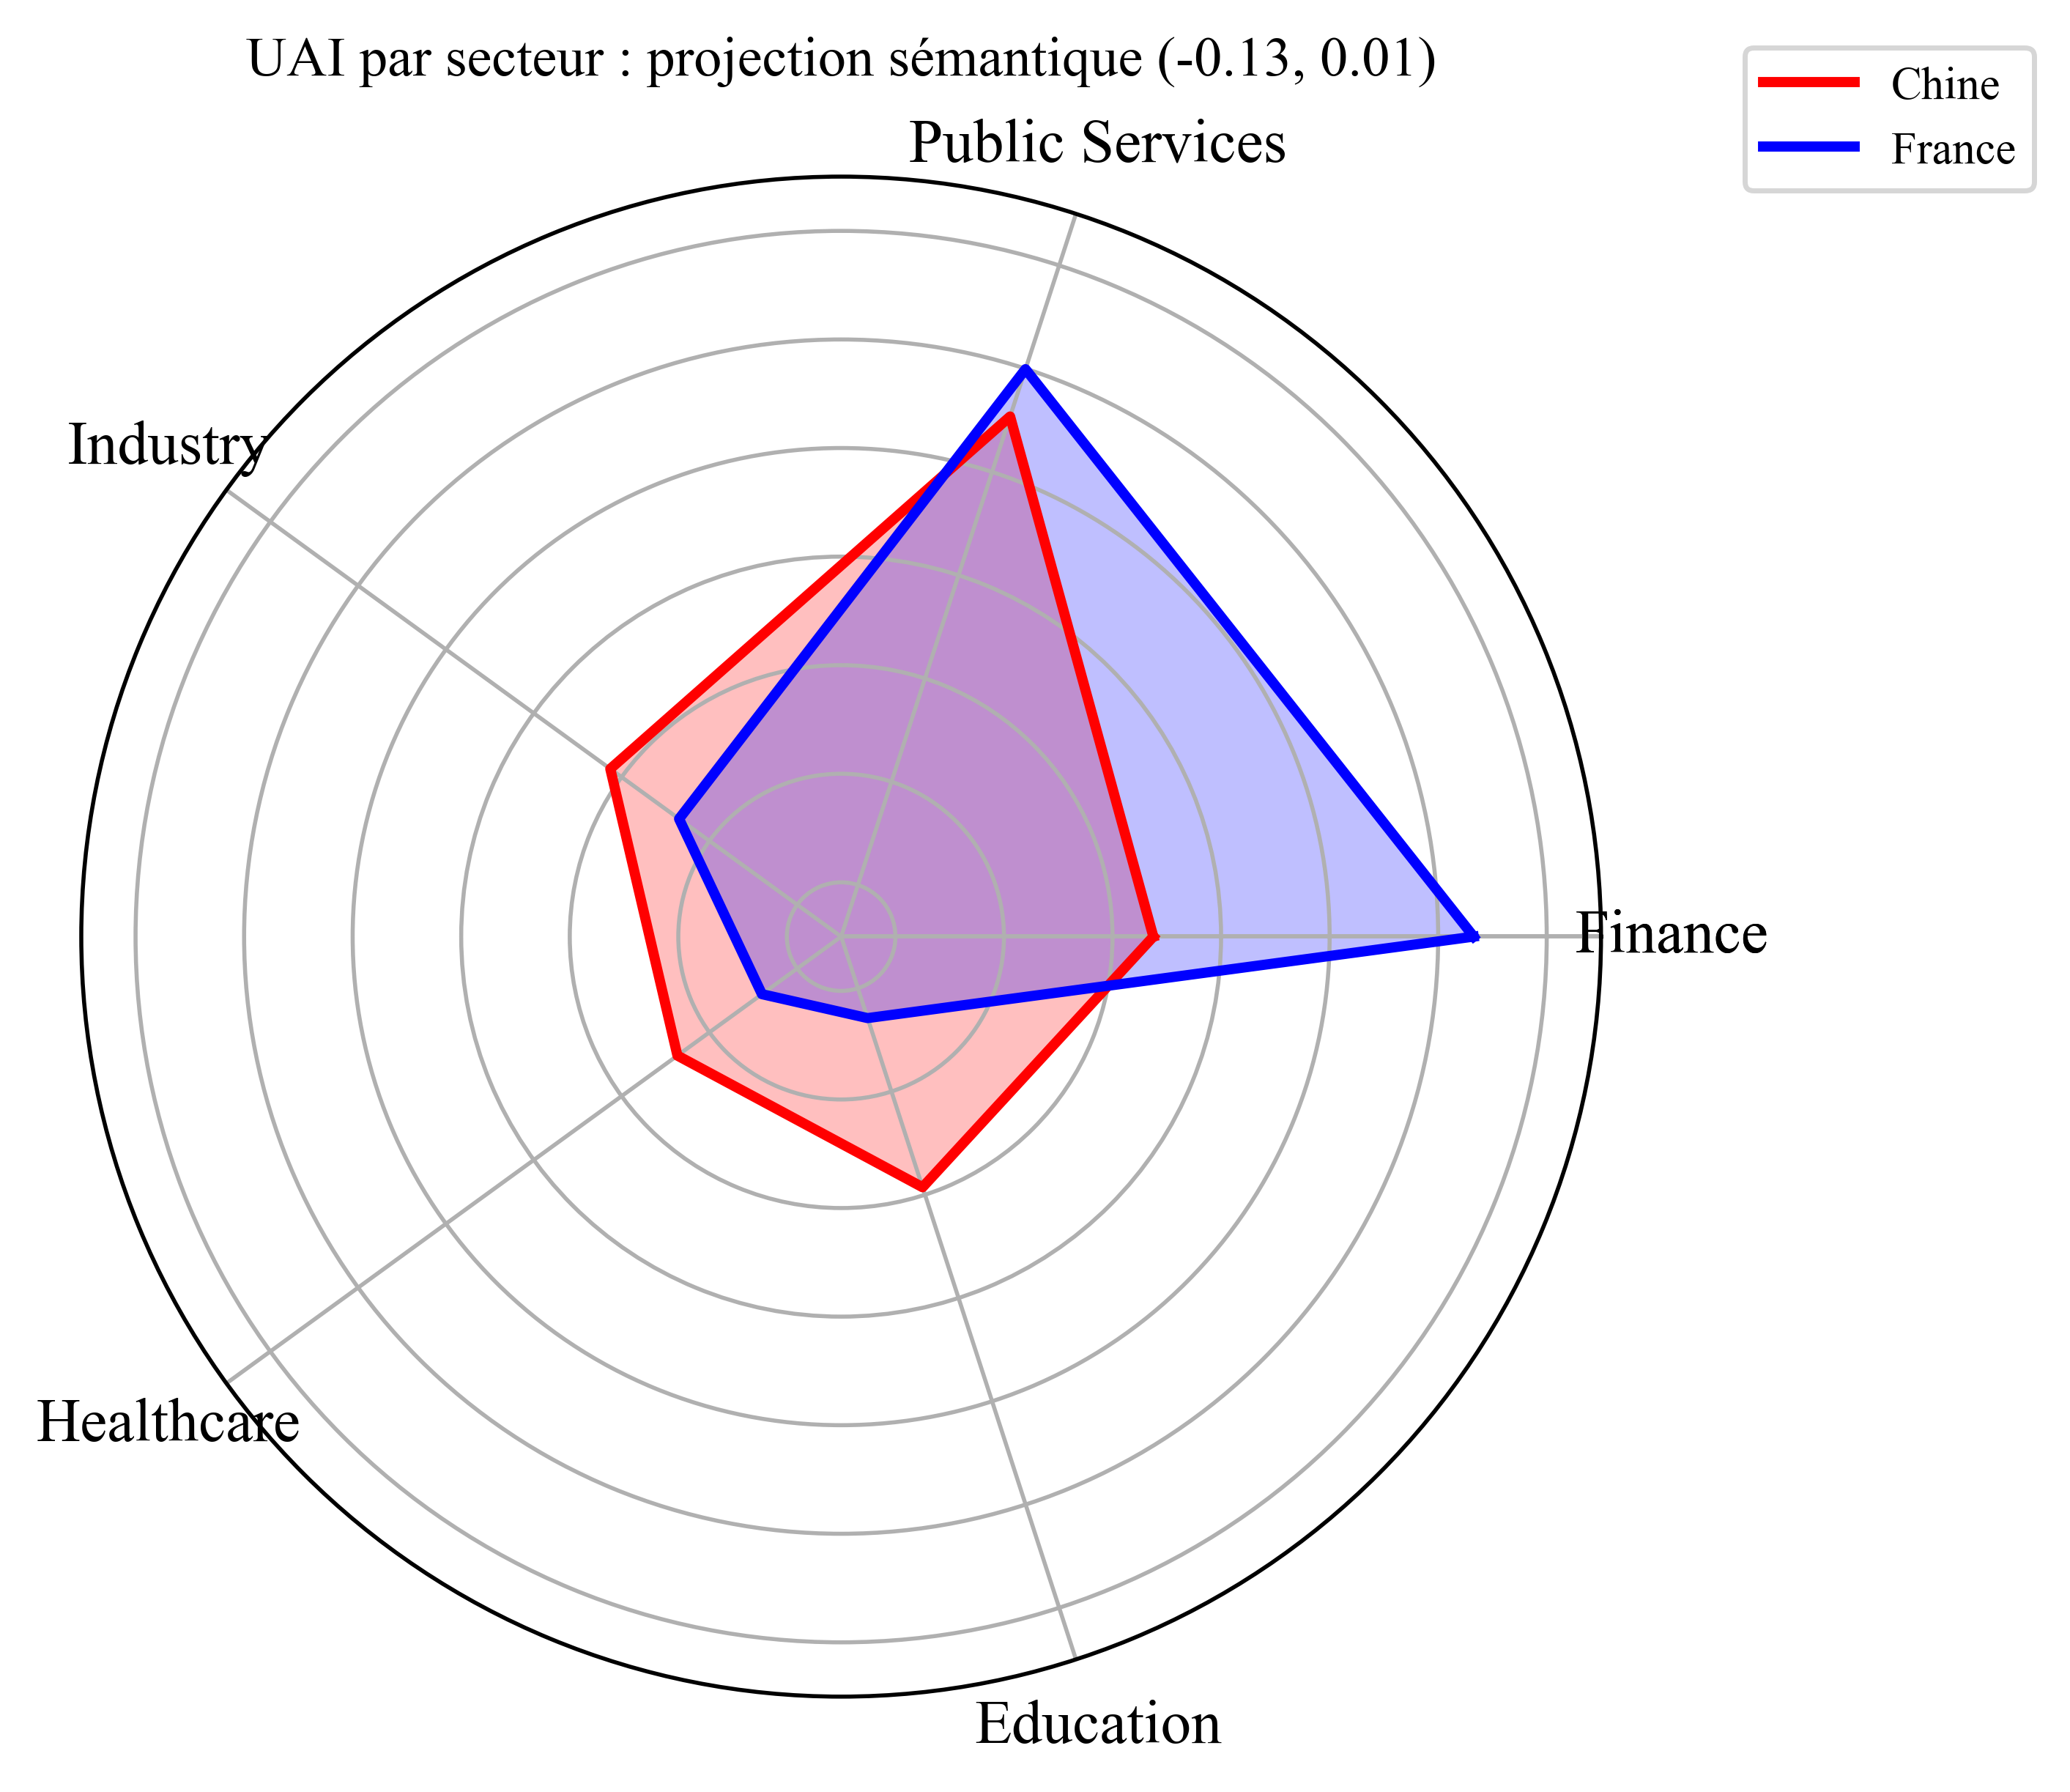

In [20]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({
    "font.size": 16,
    "axes.titlesize": 11,
    "axes.labelsize": 10,
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "font.family": "Times New Roman",
    "mathtext.fontset": "stix" 
})

sectors = list(uai_scores.keys())
n = len(sectors)

# Préparer les angles et les valeurs pour le radar
DOM_MAP = {"financial": "Finance", "public_services": "Public Services", "industrial": "Industry", "healthcare": "Healthcare", "education": "Education"}
labels = sectors + [sectors[0]]
labels = [DOM_MAP[s] for s in labels]
angles = np.linspace(0, 2 * np.pi, n, endpoint=False).tolist()
angles += angles[:1]

china_vals = [uai_scores[s]['china'] for s in sectors]
france_vals = [uai_scores[s]['france'] for s in sectors]
china_vals += china_vals[:1]
france_vals += france_vals[:1]

# Création du plot
fig, ax = plt.subplots(figsize=(6,6), subplot_kw={'polar': True}, dpi=500)

ax.plot(angles, china_vals, color='red', linewidth=2, label='Chine')
ax.fill(angles, china_vals, color='red', alpha=0.25)

ax.plot(angles, france_vals, color='blue', linewidth=2, label='France')
ax.fill(angles, france_vals, color='blue', alpha=0.25)

ax.set_thetagrids(np.degrees(angles), labels, fontsize=12)
ax.set_title(f"UAI par secteur : projection sémantique (-0.13, 0.01)", pad=20)

ax.set_ylim(-0.13, 0.01)
ax.set_yticklabels([])

ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.savefig("uai_radar_plot.svg", dpi=500, bbox_inches='tight', format='svg')
plt.show()
